In [1]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image


In [2]:
!nvidia-smi

Mon Apr  1 09:21:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   31C    P8              15W / 250W |    480MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [29]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [22]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# read /mnt/nfs/work/c98181/RL/dataset/CartPole-v1...npy
observations= np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_1M_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_1M_actions.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape)
print(observations[0], actions[0])

# print(actions)

(1000000, 4) (1000000,)
[-0.03013654  0.21001437 -0.04612853 -0.34675622] 1


In [16]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [7]:
policy_network = PolicyNetwork(
    4, 2).to(device)


prev = PolicyNetwork(
    4, 2).to(device)


optimizer = torch.optim.Adam(policy_network.parameters(), lr=(1e-3))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)


# Training loop
num_epochs = 300
batch_size = 512

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    loss_record=[]
    # step=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)
        if step % 100 == 0:
          prev.load_state_dict(policy_network.state_dict())
          prev.eval()
        # Get the log probabilities of the actions
        
        softmax = policy_network(obs_batch)
        # print(softmax.shape, act_batch.shape)
        model_act_sample = Categorical(softmax).sample()
        policy_chosen_logps = Categorical(softmax).log_prob(act_batch)
        policy_rejected_logps = Categorical(softmax).log_prob(model_act_sample)
        with torch.no_grad():
            reference_chosen_logps = Categorical(prev(obs_batch)).log_prob(act_batch)
            reference_rejected_logps = Categorical(prev(obs_batch)).log_prob(model_act_sample)
          

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        # chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        # reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch <= 10:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          losses = (
                  -F.logsigmoid(beta * logits)
              )
          # loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
          loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        #scheduler

        loss_record.append(loss.detach().item())
    scheduler.step()
    graph.append(sum(loss_record)/len(loss_record))

    policy_network.eval()  # 切换到评估模式

    env = make_vec_env(env_id, n_envs=1)

    state = env.reset()
    done = False
    total_reward=0
    # test the policy and save as gif
    frames = []
    while not done:
        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
        with torch.no_grad():
            action = Categorical(policy_network(state_tensor)).sample().cpu().numpy()[0]
            
        state, reward, done, _ = env.step(action)  # 执行动作
        total_reward += reward
        frame = env.render(mode="rgb_array")  # 获取当前环境的图像
        frames.append(frame)  # 添加到帧列表中

    # 保存为GIF
    image_path = f"cartpole_epoch_{epoch+1}.gif"
    imageio.mimsave("/mnt/nfs/work/c98181/RL/result/"+env_id+"/"+image_path, frames, duration=0.04)  # duration控制帧切换的速度


    env.close()
    print(total_reward)
    eval_rewards.append(total_reward)

  0%|          | 0/1954 [00:00<?, ?it/s]/tmp/ipykernel_497392/3279370013.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
Epoch [1/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.57it/s, loss=0.0752, positive_reward=-.00505, negative_reward=0.0153, margin=-.0204]    


[43.]


Epoch [2/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.40it/s, loss=0.096, positive_reward=0.0228, negative_reward=0.025, margin=-.00223]      


[12.]


Epoch [3/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.30it/s, loss=0.0925, positive_reward=-.00274, negative_reward=-.00559, margin=0.00285]  


[11.]


Epoch [4/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.13it/s, loss=0.223, positive_reward=0.00562, negative_reward=0.0605, margin=-.0549]      


[14.]


Epoch [5/300]: 100%|██████████| 1954/1954 [00:13<00:00, 139.60it/s, loss=0.07, positive_reward=0.00644, negative_reward=0.005, margin=0.00143]       


[15.]


Epoch [6/300]: 100%|██████████| 1954/1954 [00:14<00:00, 137.85it/s, loss=0.106, positive_reward=0.00264, negative_reward=-.00127, margin=0.00391]   


[12.]


Epoch [7/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.46it/s, loss=0.0794, positive_reward=0.00988, negative_reward=-.00395, margin=0.0138]    


[18.]


Epoch [8/300]: 100%|██████████| 1954/1954 [00:14<00:00, 138.16it/s, loss=0.119, positive_reward=-.00363, negative_reward=0.00147, margin=-.0051]    


[13.]


Epoch [9/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.23it/s, loss=0.191, positive_reward=-.0275, negative_reward=0.00574, margin=-.0332]      


[17.]


Epoch [10/300]: 100%|██████████| 1954/1954 [00:14<00:00, 139.40it/s, loss=0.192, positive_reward=0.0298, negative_reward=-.0226, margin=0.0524]       


[15.]


Epoch [11/300]: 100%|██████████| 1954/1954 [00:14<00:00, 138.31it/s, loss=0.146, positive_reward=-.0179, negative_reward=0.0408, margin=-.0587]       


[27.]


Epoch [12/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.22it/s, loss=0.724, positive_reward=-.0202, negative_reward=0.0286, margin=-.0488]      


[27.]


Epoch [13/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.30it/s, loss=0.712, positive_reward=0.002, negative_reward=0.0297, margin=-.0277]       


[49.]


Epoch [14/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.37it/s, loss=0.69, positive_reward=0.00581, negative_reward=-.00196, margin=0.00777]    


[23.]


Epoch [15/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.74it/s, loss=0.699, positive_reward=-.00859, negative_reward=0.00138, margin=-.00997]   


[18.]


Epoch [16/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.53it/s, loss=0.691, positive_reward=0.00777, negative_reward=0.00251, margin=0.00527]   


[11.]


Epoch [17/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.25it/s, loss=0.694, positive_reward=0.00137, negative_reward=0.00362, margin=-.00225]   


[13.]


Epoch [18/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.81it/s, loss=0.706, positive_reward=-.00857, negative_reward=0.0131, margin=-.0216]     


[39.]


Epoch [19/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.85it/s, loss=0.69, positive_reward=0.00949, negative_reward=0.00274, margin=0.00674]    


[22.]


Epoch [20/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.16it/s, loss=0.692, positive_reward=0.0114, negative_reward=0.00843, margin=0.00299]    


[19.]


Epoch [21/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.58it/s, loss=0.692, positive_reward=0.00513, negative_reward=0.00153, margin=0.0036]    


[19.]


Epoch [22/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.36it/s, loss=0.701, positive_reward=-.0175, negative_reward=-.00331, margin=-.0142]     


[14.]


Epoch [23/300]: 100%|██████████| 1954/1954 [00:14<00:00, 135.24it/s, loss=0.702, positive_reward=-.00337, negative_reward=0.0113, margin=-.0147]     


[19.]


Epoch [24/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.22it/s, loss=0.695, positive_reward=-.01, negative_reward=-.0145, margin=0.00449]       


[21.]


Epoch [25/300]: 100%|██████████| 1954/1954 [00:14<00:00, 135.11it/s, loss=0.701, positive_reward=-.0091, negative_reward=0.00375, margin=-.0129]     


[12.]


Epoch [26/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.08it/s, loss=0.71, positive_reward=0.00248, negative_reward=0.0281, margin=-.0256]      


[18.]


Epoch [27/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.73it/s, loss=0.702, positive_reward=-.00743, negative_reward=0.00721, margin=-.0146]    


[27.]


Epoch [28/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.39it/s, loss=0.71, positive_reward=-.00995, negative_reward=0.0156, margin=-.0255]      


[49.]


Epoch [29/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.76it/s, loss=0.683, positive_reward=0.00889, negative_reward=-.0145, margin=0.0234]     


[16.]


Epoch [30/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.31it/s, loss=0.698, positive_reward=-.00488, negative_reward=0.00248, margin=-.00736]   


[27.]


Epoch [31/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.08it/s, loss=0.696, positive_reward=-.00594, negative_reward=-.000581, margin=-.00536]  


[16.]


Epoch [32/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.00it/s, loss=0.709, positive_reward=-.0224, negative_reward=-.00765, margin=-.0147]     


[24.]


Epoch [33/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.33it/s, loss=0.697, positive_reward=-.00669, negative_reward=-.00412, margin=-.00257]   


[12.]


Epoch [34/300]: 100%|██████████| 1954/1954 [00:14<00:00, 130.82it/s, loss=0.7, positive_reward=0.00677, negative_reward=0.0175, margin=-.0108]       


[32.]


Epoch [35/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.19it/s, loss=0.691, positive_reward=0.0035, negative_reward=-.00181, margin=0.0053]     


[21.]


Epoch [36/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.82it/s, loss=0.696, positive_reward=0.0113, negative_reward=0.0171, margin=-.00578]     


[15.]


Epoch [37/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.19it/s, loss=0.695, positive_reward=0.00217, negative_reward=0.00649, margin=-.00432]   


[11.]


Epoch [38/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.04it/s, loss=0.687, positive_reward=0.0133, negative_reward=-.00495, margin=0.0183]     


[31.]


Epoch [39/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.06it/s, loss=0.702, positive_reward=0.0084, negative_reward=0.0246, margin=-.0162]      


[20.]


Epoch [40/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.28it/s, loss=0.703, positive_reward=-.00766, negative_reward=0.0108, margin=-.0184]     


[23.]


Epoch [41/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.46it/s, loss=0.705, positive_reward=-.0096, negative_reward=0.00745, margin=-.017]      


[33.]


Epoch [42/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.84it/s, loss=0.695, positive_reward=0.0122, negative_reward=0.012, margin=0.00018]      


[13.]


Epoch [43/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.86it/s, loss=0.698, positive_reward=0.011, negative_reward=0.0173, margin=-.00631]      


[29.]


Epoch [44/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.10it/s, loss=0.686, positive_reward=0.0173, negative_reward=0.00117, margin=0.0161]     


[10.]


Epoch [45/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.70it/s, loss=0.696, positive_reward=0.0104, negative_reward=0.0131, margin=-.00263]     


[35.]


Epoch [46/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.19it/s, loss=0.695, positive_reward=0.00866, negative_reward=0.00814, margin=0.000519]  


[13.]


Epoch [47/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.75it/s, loss=0.691, positive_reward=0.00416, negative_reward=-.000397, margin=0.00456]  


[9.]


Epoch [48/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.35it/s, loss=0.714, positive_reward=-.00924, negative_reward=0.00365, margin=-.0129]    


[13.]


Epoch [49/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.99it/s, loss=0.693, positive_reward=0.00697, negative_reward=0.00475, margin=0.00222]   


[18.]


Epoch [50/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.86it/s, loss=0.689, positive_reward=0.00594, negative_reward=-.00373, margin=0.00966]   


[13.]


Epoch [51/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.28it/s, loss=0.687, positive_reward=0.00256, negative_reward=-.0135, margin=0.0161]     


[19.]


Epoch [52/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.14it/s, loss=0.701, positive_reward=-.0047, negative_reward=0.00869, margin=-.0134]     


[11.]


Epoch [53/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.13it/s, loss=0.694, positive_reward=0.00619, negative_reward=0.0081, margin=-.00191]    


[26.]


Epoch [54/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.70it/s, loss=0.711, positive_reward=-.00634, negative_reward=0.0196, margin=-.0259]     


[9.]


Epoch [55/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.81it/s, loss=0.691, positive_reward=0.0019, negative_reward=-.00366, margin=0.00556]    


[17.]


Epoch [56/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.09it/s, loss=0.693, positive_reward=0.00549, negative_reward=0.00448, margin=0.00102]   


[12.]


Epoch [57/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.28it/s, loss=0.695, positive_reward=0.00178, negative_reward=0.00505, margin=-.00327]   


[15.]


Epoch [58/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.52it/s, loss=0.693, positive_reward=-.00351, negative_reward=-.00351, margin=0]         


[16.]


Epoch [59/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.78it/s, loss=0.688, positive_reward=0.0168, negative_reward=-.00307, margin=0.0198]     


[35.]


Epoch [60/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.98it/s, loss=0.699, positive_reward=-.00508, negative_reward=0.00649, margin=-.0116]    


[20.]


Epoch [61/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.01it/s, loss=0.709, positive_reward=-.0125, negative_reward=0.0127, margin=-.0252]      


[38.]


Epoch [62/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.31it/s, loss=0.699, positive_reward=-.00937, negative_reward=0.000801, margin=-.0102]   


[22.]


Epoch [63/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.90it/s, loss=0.692, positive_reward=-7.91e-5, negative_reward=-.00335, margin=0.00327]  


[13.]


Epoch [64/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.99it/s, loss=0.706, positive_reward=0.00133, negative_reward=0.0228, margin=-.0215]     


[20.]


Epoch [65/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.12it/s, loss=0.711, positive_reward=-.0208, negative_reward=0.00945, margin=-.0302]     


[43.]


Epoch [66/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.09it/s, loss=0.698, positive_reward=-.00591, negative_reward=0.00233, margin=-.00825]   


[22.]


Epoch [67/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.91it/s, loss=0.685, positive_reward=0.00939, negative_reward=-.00802, margin=0.0174]    


[21.]


Epoch [68/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.03it/s, loss=0.687, positive_reward=0.00313, negative_reward=-.00927, margin=0.0124]    


[20.]


Epoch [69/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.86it/s, loss=0.69, positive_reward=0.0101, negative_reward=0.00316, margin=0.00698]     


[13.]


Epoch [70/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.82it/s, loss=0.685, positive_reward=0.0119, negative_reward=-.00605, margin=0.0179]     


[25.]


Epoch [71/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.27it/s, loss=0.703, positive_reward=0.00577, negative_reward=0.0221, margin=-.0163]     


[14.]


Epoch [72/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.83it/s, loss=0.692, positive_reward=0.00576, negative_reward=0.00124, margin=0.00452]   


[20.]


Epoch [73/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.02it/s, loss=0.711, positive_reward=-.0205, negative_reward=0.00928, margin=-.0298]     


[32.]


Epoch [74/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.72it/s, loss=0.696, positive_reward=-.00379, negative_reward=0.00256, margin=-.00635]   


[26.]


Epoch [75/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.92it/s, loss=0.693, positive_reward=-.00246, negative_reward=-.00712, margin=0.00466]   


[26.]


Epoch [76/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.33it/s, loss=0.691, positive_reward=7.06e-5, negative_reward=-.00837, margin=0.00844]   


[14.]


Epoch [77/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.79it/s, loss=0.695, positive_reward=0.0119, negative_reward=0.0136, margin=-.0017]      


[26.]


Epoch [78/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.76it/s, loss=0.701, positive_reward=-.00909, negative_reward=0.00538, margin=-.0145]    


[17.]


Epoch [79/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.54it/s, loss=0.676, positive_reward=0.0272, negative_reward=-.0226, margin=0.0498]      


[29.]


Epoch [80/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.57it/s, loss=0.687, positive_reward=0.0139, negative_reward=0.000471, margin=0.0134]    


[13.]


Epoch [81/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.74it/s, loss=0.7, positive_reward=-.0111, negative_reward=0.00232, margin=-.0134]       


[13.]


Epoch [82/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.03it/s, loss=0.683, positive_reward=0.0248, negative_reward=-.000339, margin=0.0252]    


[14.]


Epoch [83/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.92it/s, loss=0.693, positive_reward=-.00461, negative_reward=-.00461, margin=0]         


[22.]


Epoch [84/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.01it/s, loss=0.69, positive_reward=0.00059, negative_reward=-.0149, margin=0.0155]      


[11.]


Epoch [85/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.68it/s, loss=0.703, positive_reward=0.00407, negative_reward=0.0184, margin=-.0143]     


[10.]


Epoch [86/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.82it/s, loss=0.699, positive_reward=0.0039, negative_reward=0.0116, margin=-.00767]     


[19.]


Epoch [87/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.36it/s, loss=0.693, positive_reward=0.00312, negative_reward=-.0077, margin=0.0108]     


[46.]


Epoch [88/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.61it/s, loss=0.693, positive_reward=-.00123, negative_reward=-.00786, margin=0.00663]   


[12.]


Epoch [89/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.07it/s, loss=0.689, positive_reward=0.0362, negative_reward=0.0203, margin=0.016]       


[14.]


Epoch [90/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.73it/s, loss=0.7, positive_reward=0.00454, negative_reward=0.0163, margin=-.0118]       


[12.]


Epoch [91/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.34it/s, loss=0.697, positive_reward=-.0174, negative_reward=-.0107, margin=-.00677]     


[62.]


Epoch [92/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.27it/s, loss=0.705, positive_reward=-.00287, negative_reward=0.018, margin=-.0209]      


[24.]


Epoch [93/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.12it/s, loss=0.715, positive_reward=-.00393, negative_reward=0.0266, margin=-.0305]     


[33.]


Epoch [94/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.12it/s, loss=0.707, positive_reward=-.00501, negative_reward=0.0179, margin=-.023]      


[16.]


Epoch [95/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.66it/s, loss=0.696, positive_reward=-.00591, negative_reward=-.000861, margin=-.00505]  


[15.]


Epoch [96/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.47it/s, loss=0.693, positive_reward=0.00603, negative_reward=0.00572, margin=0.000312]  


[47.]


Epoch [97/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.15it/s, loss=0.7, positive_reward=0.0118, negative_reward=0.0174, margin=-.00557]       


[21.]


Epoch [98/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.09it/s, loss=0.694, positive_reward=0.00518, negative_reward=0.00582, margin=-.000646]  


[15.]


Epoch [99/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.29it/s, loss=0.718, positive_reward=-.00316, negative_reward=0.0327, margin=-.0359]     


[10.]


Epoch [100/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.50it/s, loss=0.695, positive_reward=0.00295, negative_reward=0.00734, margin=-.00439]   


[15.]


Epoch [101/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.35it/s, loss=0.686, positive_reward=0.0137, negative_reward=-.00949, margin=0.0232]     


[16.]


Epoch [102/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.26it/s, loss=0.717, positive_reward=0.00319, negative_reward=0.0376, margin=-.0344]     


[20.]


Epoch [103/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.59it/s, loss=0.693, positive_reward=-.00319, negative_reward=-.00319, margin=0]         


[16.]


Epoch [104/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.68it/s, loss=0.701, positive_reward=-.00939, negative_reward=3.33e-5, margin=-.00942]   


[18.]


Epoch [105/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.71it/s, loss=0.669, positive_reward=0.0541, negative_reward=-.0104, margin=0.0645]      


[22.]


Epoch [106/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.96it/s, loss=0.694, positive_reward=-.000658, negative_reward=0.000257, margin=-.000915]


[10.]


Epoch [107/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.40it/s, loss=0.697, positive_reward=-.0144, negative_reward=-.0115, margin=-.00298]     


[36.]


Epoch [108/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.08it/s, loss=0.694, positive_reward=-.000418, negative_reward=0.000203, margin=-.00062] 


[46.]


Epoch [109/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.89it/s, loss=0.691, positive_reward=0.0115, negative_reward=0.00612, margin=0.00542]    


[22.]


Epoch [110/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.72it/s, loss=0.699, positive_reward=-.0152, negative_reward=-.00402, margin=-.0111]     


[20.]


Epoch [111/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.16it/s, loss=0.69, positive_reward=-.00428, negative_reward=-.0119, margin=0.00766]     


[21.]


Epoch [112/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.99it/s, loss=0.703, positive_reward=-.0115, negative_reward=0.00275, margin=-.0143]     


[29.]


Epoch [113/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.62it/s, loss=0.72, positive_reward=-.0257, negative_reward=0.0108, margin=-.0365]       


[37.]


Epoch [114/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.78it/s, loss=0.715, positive_reward=-.00756, negative_reward=0.0255, margin=-.0331]     


[13.]


Epoch [115/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.83it/s, loss=0.693, positive_reward=0.00507, negative_reward=0.00493, margin=0.000136]  


[43.]


Epoch [116/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.86it/s, loss=0.7, positive_reward=-.000517, negative_reward=0.00635, margin=-.00686]    


[16.]


Epoch [117/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.70it/s, loss=0.715, positive_reward=-.0222, negative_reward=0.0152, margin=-.0374]      


[21.]


Epoch [118/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.15it/s, loss=0.69, positive_reward=0.00659, negative_reward=-.00244, margin=0.00903]    


[33.]


Epoch [119/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.32it/s, loss=0.717, positive_reward=-.0168, negative_reward=0.017, margin=-.0338]       


[15.]


Epoch [120/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.31it/s, loss=0.688, positive_reward=-.000565, negative_reward=-.0131, margin=0.0125]    


[16.]


Epoch [121/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.63it/s, loss=0.697, positive_reward=0.0085, negative_reward=0.0151, margin=-.00658]     


[30.]


Epoch [122/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.79it/s, loss=0.681, positive_reward=0.0274, negative_reward=-.00176, margin=0.0292]     


[48.]


Epoch [123/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.39it/s, loss=0.689, positive_reward=0.016, negative_reward=0.00555, margin=0.0104]      


[18.]


Epoch [124/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.59it/s, loss=0.689, positive_reward=0.0109, negative_reward=-.00312, margin=0.014]      


[14.]


Epoch [125/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.28it/s, loss=0.697, positive_reward=-.00818, negative_reward=-.000708, margin=-.00747]  


[14.]


Epoch [126/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.99it/s, loss=0.699, positive_reward=-.0129, negative_reward=-.00334, margin=-.00951]    


[18.]


Epoch [127/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.84it/s, loss=0.696, positive_reward=-.0043, negative_reward=0.00127, margin=-.00557]    


[14.]


Epoch [128/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.17it/s, loss=0.704, positive_reward=-.00714, negative_reward=0.0117, margin=-.0189]     


[10.]


Epoch [129/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.53it/s, loss=0.695, positive_reward=-.00134, negative_reward=0.00218, margin=-.00352]   


[25.]


Epoch [130/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.06it/s, loss=0.693, positive_reward=0.00337, negative_reward=0.00337, margin=0]         


[9.]


Epoch [131/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.21it/s, loss=0.693, positive_reward=-8.06e-5, negative_reward=-.00054, margin=0.000459] 


[16.]


Epoch [132/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.65it/s, loss=0.707, positive_reward=0.000284, negative_reward=0.0243, margin=-.024]     


[20.]


Epoch [133/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.97it/s, loss=0.71, positive_reward=-.0105, negative_reward=0.0147, margin=-.0251]       


[31.]


Epoch [134/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.60it/s, loss=0.696, positive_reward=-.00148, negative_reward=0.00335, margin=-.00483]   


[17.]


Epoch [135/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.38it/s, loss=0.712, positive_reward=0.0218, negative_reward=0.0508, margin=-.0291]      


[25.]


Epoch [136/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.26it/s, loss=0.694, positive_reward=0.00621, negative_reward=0.0073, margin=-.00109]    


[23.]


Epoch [137/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.59it/s, loss=0.704, positive_reward=-.00907, negative_reward=0.00977, margin=-.0188]    


[28.]


Epoch [138/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.80it/s, loss=0.693, positive_reward=0.00681, negative_reward=0.00681, margin=0]         


[52.]


Epoch [139/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.44it/s, loss=0.693, positive_reward=-.00344, negative_reward=-.00344, margin=0]         


[16.]


Epoch [140/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.48it/s, loss=0.714, positive_reward=-.00649, negative_reward=0.0259, margin=-.0324]     


[23.]


Epoch [141/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.98it/s, loss=0.712, positive_reward=-.00542, negative_reward=0.0272, margin=-.0326]     


[27.]


Epoch [142/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.07it/s, loss=0.704, positive_reward=-.00394, negative_reward=0.00743, margin=-.0114]    


[23.]


Epoch [143/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.92it/s, loss=0.713, positive_reward=-.0163, negative_reward=0.0188, margin=-.0351]      


[27.]


Epoch [144/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.74it/s, loss=0.692, positive_reward=-.000933, negative_reward=-.00261, margin=0.00167]  


[31.]


Epoch [145/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.40it/s, loss=0.702, positive_reward=-.0229, negative_reward=-.0102, margin=-.0127]      


[20.]


Epoch [146/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.31it/s, loss=0.693, positive_reward=0.00145, negative_reward=-.000446, margin=0.00189]  


[31.]


Epoch [147/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.87it/s, loss=0.695, positive_reward=0.00388, negative_reward=0.00463, margin=-.00075]   


[31.]


Epoch [148/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.59it/s, loss=0.704, positive_reward=9.54e-5, negative_reward=0.0161, margin=-.016]      


[16.]


Epoch [149/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.14it/s, loss=0.692, positive_reward=0.0038, negative_reward=5.03e-6, margin=0.00379]    


[15.]


Epoch [150/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.31it/s, loss=0.699, positive_reward=-.00852, negative_reward=0.000441, margin=-.00896]  


[24.]


Epoch [151/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.20it/s, loss=0.696, positive_reward=0.00177, negative_reward=0.00554, margin=-.00376]   


[29.]


Epoch [152/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.11it/s, loss=0.712, positive_reward=-.0301, negative_reward=0.000429, margin=-.0305]    


[31.]


Epoch [153/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.78it/s, loss=0.704, positive_reward=-.0067, negative_reward=0.0105, margin=-.0172]      


[10.]


Epoch [154/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.02it/s, loss=0.709, positive_reward=-.00336, negative_reward=-.00369, margin=0.000334]  


[16.]


Epoch [155/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.69it/s, loss=0.689, positive_reward=0.0014, negative_reward=-.00937, margin=0.0108]     


[29.]


Epoch [156/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.76it/s, loss=0.695, positive_reward=0.0073, negative_reward=0.00272, margin=0.00458]    


[16.]


Epoch [157/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.96it/s, loss=0.696, positive_reward=-.0032, negative_reward=0.00241, margin=-.00561]    


[20.]


Epoch [158/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.63it/s, loss=0.69, positive_reward=0.00203, negative_reward=-.00569, margin=0.00772]    


[18.]


Epoch [159/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.47it/s, loss=0.693, positive_reward=0.000162, negative_reward=0.000162, margin=0]       


[27.]


Epoch [160/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.75it/s, loss=0.695, positive_reward=-.0157, negative_reward=-.0117, margin=-.00398]     


[29.]


Epoch [161/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.33it/s, loss=0.699, positive_reward=-.0082, negative_reward=-.00253, margin=-.00567]    


[17.]


Epoch [162/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.28it/s, loss=0.689, positive_reward=-.00481, negative_reward=-.0135, margin=0.0087]     


[13.]


Epoch [163/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.52it/s, loss=0.699, positive_reward=0.00473, negative_reward=0.0127, margin=-.008]      


[33.]


Epoch [164/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.63it/s, loss=0.69, positive_reward=0.00429, negative_reward=-.00234, margin=0.00663]    


[10.]


Epoch [165/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.32it/s, loss=0.693, positive_reward=0.00512, negative_reward=0.00512, margin=0]         


[23.]


Epoch [166/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.64it/s, loss=0.684, positive_reward=0.0154, negative_reward=-.00659, margin=0.022]      


[26.]


Epoch [167/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.66it/s, loss=0.733, positive_reward=0.000563, negative_reward=0.049, margin=-.0484]     


[19.]


Epoch [168/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.28it/s, loss=0.696, positive_reward=-.000762, negative_reward=0.00388, margin=-.00464]  


[25.]


Epoch [169/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.05it/s, loss=0.705, positive_reward=-.00634, negative_reward=0.0103, margin=-.0167]     


[26.]


Epoch [170/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.60it/s, loss=0.696, positive_reward=-.00301, negative_reward=-.000253, margin=-.00276]  


[13.]


Epoch [171/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.45it/s, loss=0.689, positive_reward=0.00783, negative_reward=-.00395, margin=0.0118]    


[13.]


Epoch [172/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.14it/s, loss=0.692, positive_reward=0.0195, negative_reward=0.0155, margin=0.00394]     


[28.]


Epoch [173/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.84it/s, loss=0.693, positive_reward=0.00825, negative_reward=0.00816, margin=9.47e-5]   


[12.]


Epoch [174/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.97it/s, loss=0.684, positive_reward=0.0249, negative_reward=0.00164, margin=0.0233]     


[13.]


Epoch [175/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.59it/s, loss=0.682, positive_reward=0.0337, negative_reward=0.00451, margin=0.0292]     


[11.]


Epoch [176/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.90it/s, loss=0.701, positive_reward=-.0119, negative_reward=0.00179, margin=-.0137]     


[12.]


Epoch [177/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.25it/s, loss=0.699, positive_reward=-.0144, negative_reward=-.00364, margin=-.0107]     


[11.]


Epoch [178/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.29it/s, loss=0.707, positive_reward=-.019, negative_reward=0.00275, margin=-.0217]      


[30.]


Epoch [179/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.50it/s, loss=0.703, positive_reward=-.0207, negative_reward=-.00285, margin=-.0179]     


[17.]


Epoch [180/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.37it/s, loss=0.691, positive_reward=0.00368, negative_reward=-.00146, margin=0.00514]   


[19.]


Epoch [181/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.67it/s, loss=0.692, positive_reward=-.0142, negative_reward=-.0173, margin=0.00315]     


[20.]


Epoch [182/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.76it/s, loss=0.718, positive_reward=0.0238, negative_reward=0.0573, margin=-.0335]      


[28.]


Epoch [183/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.87it/s, loss=0.709, positive_reward=-.0036, negative_reward=0.0124, margin=-.016]       


[46.]


Epoch [184/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.37it/s, loss=0.702, positive_reward=-.00382, negative_reward=0.0104, margin=-.0142]     


[13.]


Epoch [185/300]: 100%|██████████| 1954/1954 [00:14<00:00, 134.15it/s, loss=0.68, positive_reward=0.00343, negative_reward=-.0293, margin=0.0327]      


[34.]


Epoch [186/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.28it/s, loss=0.697, positive_reward=-.00292, negative_reward=0.00467, margin=-.00759]   


[23.]


Epoch [187/300]: 100%|██████████| 1954/1954 [00:14<00:00, 135.05it/s, loss=0.702, positive_reward=0.0134, negative_reward=0.0298, margin=-.0164]      


[42.]


Epoch [188/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.25it/s, loss=0.697, positive_reward=0.00113, negative_reward=0.00833, margin=-.0072]    


[18.]


Epoch [189/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.94it/s, loss=0.705, positive_reward=-.0244, negative_reward=-.00978, margin=-.0146]     


[15.]


Epoch [190/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.55it/s, loss=0.691, positive_reward=0.00144, negative_reward=-.00426, margin=0.0057]    


[10.]


Epoch [191/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.01it/s, loss=0.692, positive_reward=0.0184, negative_reward=0.0165, margin=0.00196]     


[14.]


Epoch [192/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.18it/s, loss=0.692, positive_reward=0.00362, negative_reward=0.000786, margin=0.00283]  


[11.]


Epoch [193/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.56it/s, loss=0.69, positive_reward=-.00143, negative_reward=-.0088, margin=0.00737]     


[39.]


Epoch [194/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.78it/s, loss=0.702, positive_reward=0.00295, negative_reward=0.0176, margin=-.0147]     


[16.]


Epoch [195/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.98it/s, loss=0.701, positive_reward=0.0161, negative_reward=0.0249, margin=-.00873]     


[17.]


Epoch [196/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.48it/s, loss=0.693, positive_reward=-.00707, negative_reward=-.00707, margin=0]         


[22.]


Epoch [197/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.56it/s, loss=0.698, positive_reward=0.0029, negative_reward=0.0127, margin=-.00984]     


[28.]


Epoch [198/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.90it/s, loss=0.693, positive_reward=-.00441, negative_reward=-.00441, margin=0]         


[28.]


Epoch [199/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.49it/s, loss=0.712, positive_reward=-.00234, negative_reward=0.025, margin=-.0274]      


[17.]


Epoch [200/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.48it/s, loss=0.697, positive_reward=-.000324, negative_reward=0.00566, margin=-.00599]  


[10.]


Epoch [201/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.65it/s, loss=0.694, positive_reward=-.00356, negative_reward=-.00369, margin=0.000135]  


[21.]


Epoch [202/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.57it/s, loss=0.693, positive_reward=-.00136, negative_reward=-.00136, margin=0]         


[16.]


Epoch [203/300]: 100%|██████████| 1954/1954 [00:15<00:00, 129.02it/s, loss=0.691, positive_reward=0.00291, negative_reward=-.000837, margin=0.00375]  


[14.]


Epoch [204/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.27it/s, loss=0.705, positive_reward=-.0109, negative_reward=0.0106, margin=-.0215]      


[17.]


Epoch [205/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.03it/s, loss=0.686, positive_reward=0.0046, negative_reward=-.0171, margin=0.0217]      


[23.]


Epoch [206/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.13it/s, loss=0.698, positive_reward=0.000813, negative_reward=0.00884, margin=-.00803]  


[28.]


Epoch [207/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.30it/s, loss=0.703, positive_reward=-.0113, negative_reward=0.0029, margin=-.0142]      


[11.]


Epoch [208/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.63it/s, loss=0.695, positive_reward=-.0132, negative_reward=-.0103, margin=-.00289]     


[30.]


Epoch [209/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.91it/s, loss=0.689, positive_reward=0.011, negative_reward=0.00125, margin=0.00979]     


[12.]


Epoch [210/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.50it/s, loss=0.7, positive_reward=-.00372, negative_reward=0.00873, margin=-.0124]      


[15.]


Epoch [211/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.42it/s, loss=0.706, positive_reward=-.00678, negative_reward=0.0139, margin=-.0207]     


[14.]


Epoch [212/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.80it/s, loss=0.69, positive_reward=0.0117, negative_reward=0.00349, margin=0.00826]     


[11.]


Epoch [213/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.48it/s, loss=0.69, positive_reward=0.00791, negative_reward=0.00119, margin=0.00672]    


[33.]


Epoch [214/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.45it/s, loss=0.714, positive_reward=-.0145, negative_reward=0.0177, margin=-.0322]      


[16.]


Epoch [215/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.51it/s, loss=0.696, positive_reward=0.000104, negative_reward=0.000829, margin=-.000725]


[73.]


Epoch [216/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.90it/s, loss=0.687, positive_reward=0.0017, negative_reward=-.0193, margin=0.021]       


[17.]


Epoch [217/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.33it/s, loss=0.697, positive_reward=-.00245, negative_reward=0.00419, margin=-.00664]   


[21.]


Epoch [218/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.37it/s, loss=0.693, positive_reward=-.000866, negative_reward=-.000941, margin=7.48e-5] 


[32.]


Epoch [219/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.24it/s, loss=0.706, positive_reward=-.0102, negative_reward=0.0124, margin=-.0226]      


[17.]


Epoch [220/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.67it/s, loss=0.694, positive_reward=0.0096, negative_reward=0.00532, margin=0.00428]    


[28.]


Epoch [221/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.21it/s, loss=0.702, positive_reward=-.00372, negative_reward=0.00439, margin=-.00811]   


[33.]


Epoch [222/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.42it/s, loss=0.702, positive_reward=0.00215, negative_reward=0.0135, margin=-.0114]     


[31.]


Epoch [223/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.76it/s, loss=0.71, positive_reward=-.00852, negative_reward=0.02, margin=-.0286]        


[18.]


Epoch [224/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.17it/s, loss=0.692, positive_reward=0.00744, negative_reward=0.00405, margin=0.00338]   


[36.]


Epoch [225/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.85it/s, loss=0.696, positive_reward=0.00457, negative_reward=0.00995, margin=-.00539]   


[43.]


Epoch [226/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.76it/s, loss=0.705, positive_reward=-.0032, negative_reward=0.0157, margin=-.0189]      


[17.]


Epoch [227/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.38it/s, loss=0.693, positive_reward=0.00909, negative_reward=0.00909, margin=0]         


[11.]


Epoch [228/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.16it/s, loss=0.685, positive_reward=0.0268, negative_reward=-.0019, margin=0.0287]      


[15.]


Epoch [229/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.99it/s, loss=0.691, positive_reward=5.16e-5, negative_reward=-.00533, margin=0.00538]   


[26.]


Epoch [230/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.72it/s, loss=0.685, positive_reward=0.0219, negative_reward=-.000408, margin=0.0223]    


[33.]


Epoch [231/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.93it/s, loss=0.696, positive_reward=-.00279, negative_reward=0.00214, margin=-.00493]   


[14.]


Epoch [232/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.55it/s, loss=0.687, positive_reward=-.0128, negative_reward=-.0318, margin=0.019]       


[8.]


Epoch [233/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.44it/s, loss=0.719, positive_reward=-.0361, negative_reward=0.00667, margin=-.0428]     


[12.]


Epoch [234/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.70it/s, loss=0.684, positive_reward=0.0159, negative_reward=-.00608, margin=0.022]      


[16.]


Epoch [235/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.91it/s, loss=0.687, positive_reward=0.0153, negative_reward=-.00117, margin=0.0165]     


[16.]


Epoch [236/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.92it/s, loss=0.689, positive_reward=0.00834, negative_reward=-.00273, margin=0.0111]    


[30.]


Epoch [237/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.63it/s, loss=0.698, positive_reward=-.00233, negative_reward=0.00637, margin=-.0087]    


[13.]


Epoch [238/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.70it/s, loss=0.692, positive_reward=0.00297, negative_reward=-7.97e-5, margin=0.00305]  


[26.]


Epoch [239/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.12it/s, loss=0.694, positive_reward=0.000936, negative_reward=0.00284, margin=-.0019]   


[10.]


Epoch [240/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.73it/s, loss=0.684, positive_reward=0.0313, negative_reward=0.0011, margin=0.0302]      


[11.]


Epoch [241/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.22it/s, loss=0.706, positive_reward=-.013, negative_reward=0.00857, margin=-.0216]      


[11.]


Epoch [242/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.51it/s, loss=0.686, positive_reward=-.0056, negative_reward=-.0225, margin=0.0169]      


[14.]


Epoch [243/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.38it/s, loss=0.69, positive_reward=0.006, negative_reward=-.00665, margin=0.0126]       


[13.]


Epoch [244/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.93it/s, loss=0.696, positive_reward=-.000616, negative_reward=0.00397, margin=-.00459]  


[10.]


Epoch [245/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.30it/s, loss=0.693, positive_reward=-.0045, negative_reward=-.0045, margin=0]           


[18.]


Epoch [246/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.43it/s, loss=0.698, positive_reward=-.00582, negative_reward=0.00415, margin=-.00997]   


[18.]


Epoch [247/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.14it/s, loss=0.696, positive_reward=-.0138, negative_reward=-.0105, margin=-.00325]     


[12.]


Epoch [248/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.61it/s, loss=0.69, positive_reward=-.00116, negative_reward=-.0126, margin=0.0114]      


[15.]


Epoch [249/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.07it/s, loss=0.697, positive_reward=-.0101, negative_reward=-.00548, margin=-.00462]    


[28.]


Epoch [250/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.05it/s, loss=0.703, positive_reward=-.00948, negative_reward=0.00741, margin=-.0169]    


[14.]


Epoch [251/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.37it/s, loss=0.686, positive_reward=0.0242, negative_reward=0.00831, margin=0.0159]     


[24.]


Epoch [252/300]: 100%|██████████| 1954/1954 [00:14<00:00, 133.01it/s, loss=0.692, positive_reward=0.00563, negative_reward=0.00274, margin=0.00289]   


[16.]


Epoch [253/300]: 100%|██████████| 1954/1954 [00:15<00:00, 128.32it/s, loss=0.706, positive_reward=-.00703, negative_reward=0.0135, margin=-.0205]     


[12.]


Epoch [254/300]: 100%|██████████| 1954/1954 [00:14<00:00, 132.46it/s, loss=0.691, positive_reward=0.00237, negative_reward=-.00412, margin=0.00649]   


[15.]


Epoch [255/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.93it/s, loss=0.701, positive_reward=-.00852, negative_reward=0.00491, margin=-.0134]    


[12.]


Epoch [256/300]: 100%|██████████| 1954/1954 [00:15<00:00, 128.79it/s, loss=0.693, positive_reward=-.00651, negative_reward=-.00651, margin=0]         


[25.]


Epoch [257/300]: 100%|██████████| 1954/1954 [00:14<00:00, 131.47it/s, loss=0.706, positive_reward=-.00552, negative_reward=0.0142, margin=-.0197]     


[15.]


Epoch [258/300]: 100%|██████████| 1954/1954 [00:15<00:00, 126.25it/s, loss=0.702, positive_reward=-.0133, negative_reward=0.00251, margin=-.0158]     


[10.]


Epoch [259/300]: 100%|██████████| 1954/1954 [00:15<00:00, 128.80it/s, loss=0.687, positive_reward=0.00726, negative_reward=-.00752, margin=0.0148]    


[14.]


Epoch [260/300]: 100%|██████████| 1954/1954 [00:15<00:00, 124.00it/s, loss=0.709, positive_reward=-.00909, negative_reward=0.00758, margin=-.0167]    


[29.]


Epoch [261/300]: 100%|██████████| 1954/1954 [00:16<00:00, 120.94it/s, loss=0.697, positive_reward=-.0113, negative_reward=-.00332, margin=-.00795]    


[12.]


Epoch [262/300]:  29%|██▉       | 576/1954 [00:04<00:10, 135.48it/s, loss=0.696, positive_reward=0.00136, negative_reward=0.0045, margin=-.00314]    

In [1]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()



NameError: name 'graph' is not defined

In [38]:
policy_network = PolicyNetwork(
    4, 2).to(device)


prev = PolicyNetwork(
    4, 2).to(device)


optimizer = torch.optim.Adam(policy_network.parameters(), lr=(5e-4))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)


# Training loop
num_epochs = 300
batch_size = 256

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    loss_record=[]
    # step=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)
        # if step % 300 == 0:
        #   prev.load_state_dict(policy_network.state_dict())
        #   prev.eval()
        # Get the log probabilities of the actions
        
        softmax = policy_network(obs_batch)
        # cross entropy
        loss = F.cross_entropy(softmax, act_batch.long())
        
        # # print(softmax.shape, act_batch.shape)
        # model_act_sample = Categorical(softmax).sample()
        # policy_chosen_logps = Categorical(softmax).log_prob(act_batch)
        # policy_rejected_logps = Categorical(softmax).log_prob(model_act_sample)
        # with torch.no_grad():
        #     reference_chosen_logps = Categorical(prev(obs_batch)).log_prob(act_batch)
        #     reference_rejected_logps = Categorical(prev(obs_batch)).log_prob(model_act_sample)
          

        # pi_logratios = policy_chosen_logps - policy_rejected_logps
        # ref_logratios = reference_chosen_logps - reference_rejected_logps

        # chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        # reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        

        # chosen_logratios = policy_chosen_logps - reference_chosen_logps
        # reject_logratios = policy_rejected_logps - reference_rejected_logps

        logits = chosen_logratios - reject_logratios
        
        # if epoch <= -1:
        #   loss = - (policy_chosen_logps).mean()
        # else:
        #   beta = 1
        #   losses = (
        #           -F.logsigmoid(beta * logits)
        #       )
        #   # loss = losses.mean()
        #   # losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
        #   loss = losses.mean()
        # # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        # positive_reward = chosen_logratios.detach().mean().item()
        # negative_reward = reject_logratios.detach().mean().item()
        # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        #scheduler

        loss_record.append(loss.detach().item())
    scheduler.step()
    graph.append(sum(loss_record)/len(loss_record))

    prev.load_state_dict(policy_network.state_dict())
    prev.eval()
    
    policy_network.eval()  # 切换到评估模式

    env = make_vec_env(env_id, n_envs=1)

    state = env.reset()
    done = False
    total_reward=0
    # test the policy and save as gif
    frames = []
    while not done:
        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
        with torch.no_grad():
            pred= policy_network(state_tensor)
            action = torch.argmax(pred).cpu().numpy()
            # print(action)
            
        state, reward, done, _ = env.step([action])  # 执行动作
        total_reward += reward
        frame = env.render(mode="rgb_array")  # 获取当前环境的图像
        frames.append(frame)  # 添加到帧列表中

    # 保存为GIF
    image_path = f"cartpole_epoch_{epoch+1}.gif"
    imageio.mimsave("/mnt/nfs/work/c98181/RL/result/"+env_id+"/"+image_path, frames, duration=0.04)  # duration控制帧切换的速度


    env.close()
    print(total_reward)
    eval_rewards.append(total_reward)


  0%|          | 0/3907 [00:00<?, ?it/s]

100%|██████████| 3907/3907 [00:08<00:00, 461.95it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 461.21it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 467.81it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 463.27it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 458.48it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 463.94it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 456.80it/s]


[22.]


100%|██████████| 3907/3907 [00:08<00:00, 472.28it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 461.63it/s]


[19.]


100%|██████████| 3907/3907 [00:08<00:00, 473.17it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 459.33it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 461.08it/s]


[60.]


100%|██████████| 3907/3907 [00:08<00:00, 455.33it/s]


[58.]


100%|██████████| 3907/3907 [00:08<00:00, 463.51it/s]


[20.]


100%|██████████| 3907/3907 [00:08<00:00, 462.54it/s]


[17.]


100%|██████████| 3907/3907 [00:08<00:00, 461.26it/s]


[55.]


100%|██████████| 3907/3907 [00:08<00:00, 459.41it/s]


[16.]


100%|██████████| 3907/3907 [00:08<00:00, 459.66it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 460.29it/s]


[27.]


100%|██████████| 3907/3907 [00:08<00:00, 454.38it/s]


[13.]


100%|██████████| 3907/3907 [00:08<00:00, 460.24it/s]


[55.]


100%|██████████| 3907/3907 [00:08<00:00, 468.68it/s]


[43.]


100%|██████████| 3907/3907 [00:08<00:00, 458.46it/s]


[18.]


100%|██████████| 3907/3907 [00:08<00:00, 460.32it/s]


[24.]


100%|██████████| 3907/3907 [00:08<00:00, 471.33it/s]


[41.]


100%|██████████| 3907/3907 [00:08<00:00, 462.61it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 483.10it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 460.04it/s]


[39.]


100%|██████████| 3907/3907 [00:08<00:00, 457.31it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 458.88it/s]


[43.]


100%|██████████| 3907/3907 [00:08<00:00, 459.04it/s]


[38.]


100%|██████████| 3907/3907 [00:08<00:00, 459.88it/s]


[20.]


100%|██████████| 3907/3907 [00:08<00:00, 454.10it/s]


[18.]


100%|██████████| 3907/3907 [00:08<00:00, 459.92it/s]


[8.]


100%|██████████| 3907/3907 [00:08<00:00, 461.16it/s]


[20.]


100%|██████████| 3907/3907 [00:08<00:00, 463.70it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 459.16it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 459.56it/s]


[11.]


100%|██████████| 3907/3907 [00:08<00:00, 453.34it/s]


[43.]


100%|██████████| 3907/3907 [00:08<00:00, 460.28it/s]


[20.]


100%|██████████| 3907/3907 [00:08<00:00, 462.71it/s]


[14.]


100%|██████████| 3907/3907 [00:08<00:00, 469.86it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 458.09it/s]


[33.]


100%|██████████| 3907/3907 [00:08<00:00, 459.87it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 459.27it/s]


[10.]


100%|██████████| 3907/3907 [00:09<00:00, 426.29it/s]


[14.]


100%|██████████| 3907/3907 [00:08<00:00, 462.32it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 462.68it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 480.54it/s]


[18.]


100%|██████████| 3907/3907 [00:08<00:00, 460.16it/s]


[11.]


100%|██████████| 3907/3907 [00:08<00:00, 459.18it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 459.44it/s]


[28.]


100%|██████████| 3907/3907 [00:08<00:00, 454.52it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 460.00it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 461.12it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 460.90it/s]


[35.]


100%|██████████| 3907/3907 [00:08<00:00, 459.30it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 461.32it/s]


[43.]


100%|██████████| 3907/3907 [00:08<00:00, 456.69it/s]


[27.]


100%|██████████| 3907/3907 [00:08<00:00, 474.91it/s]


[8.]


100%|██████████| 3907/3907 [00:08<00:00, 450.34it/s]


[9.]


100%|██████████| 3907/3907 [00:08<00:00, 454.22it/s]


[10.]


100%|██████████| 3907/3907 [00:08<00:00, 463.33it/s]


[8.]


100%|██████████| 3907/3907 [00:08<00:00, 461.82it/s]


[64.]


100%|██████████| 3907/3907 [00:08<00:00, 460.42it/s]


[50.]


 34%|███▎      | 1309/3907 [00:02<00:05, 460.49it/s]


KeyboardInterrupt: 

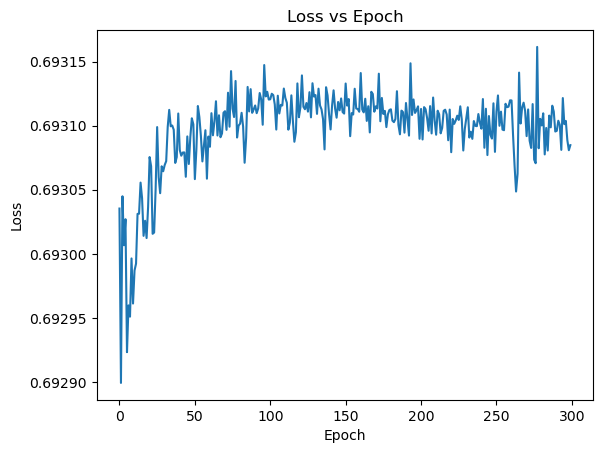

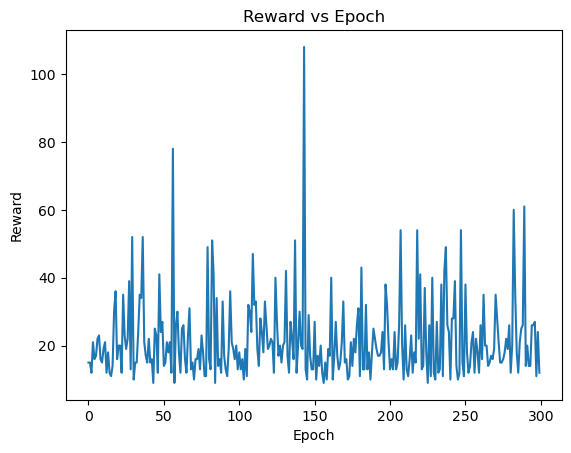

In [21]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()

